# Imputation Research Project (Zero Inflated Continuous Covariate) <img src="https://i.pinimg.com/564x/f5/8a/61/f58a61cf2d06682e309489166b5fb8fb.jpg" alt="Alt text image not displaying" width="300" align="right" style = "margin: 0 30px 0 0;"/>
## Notebook 1.1: Exploratory Data Analysis

**Author:** Chike Odenigbo

**Date:** November 22nd, 2022

**Notebook Structure:**

* 1.0 Preprocessing

* **1.1 Exploratory Data Analysis**

* 1.2 Masking

* 2.* Models


Water Sugar Alcohol

### Step 1: Import Requirements 

In [1]:
import pandas as pd
from scipy.stats import variation
from src.preprocessing.preprocessing import NumericalVariableCleaner, NumericalMasker # utility preprocessing packages found in src folder
import os
from src.visualization.visualize import histogram, box_plot, bar_plot
from itertools import chain, combinations
from pathlib import Path
from notebook_config import ROOT_DIR # setup.py file changed the root of the project so it is set in the config file
ROOT_DIR = ROOT_DIR.as_posix() # convert root path to windows readable path (i.e. change backslash to forward slash)
import json
import numpy as np
import functools as ft

In [2]:
notebook_nm = '1.1-explorations---'
fig_dir = f'{ROOT_DIR}/reports/figures/'
output_prefix = notebook_nm

In [3]:
import re
fname = 'test-what-help'
file_label = re.search('(.*?-.*?)-', fname).group(1)
file_label

'test-what'

In [4]:
nutrition_df = pd.read_csv(f'{ROOT_DIR}/data/interim/nutrition_numerical.csv')
nutrition_df

,name,serving_size,total_fat,saturated_fat,cholesterol,sodium,choline,folate,folic_acid,niacin,...,fat,saturated_fatty_acids,monounsaturated_fatty_acids,polyunsaturated_fatty_acids,fatty_acids_total_trans,alcohol,ash,caffeine,theobromine,water
0,Cornstarch,100,0.1,NaN,0,9.0,0.4,0.0,0.0,0.000,...,0.05,0.009,0.016,0.025,0.0,0.0,0.09,0.0,0.0,8.32
1,"Nuts, pecans",100,72.0,6.2,0,0.0,40.5,22.0,0.0,1.167,...,71.97,6.180,40.801,21.614,0.0,0.0,1.49,0.0,0.0,3.52
2,"Eggplant, raw",100,0.2,NaN,0,2.0,6.9,22.0,0.0,0.649,...,0.18,0.034,0.016,0.076,0.0,0.0,0.66,0.0,0.0,92.30
3,"Teff, uncooked",100,2.4,0.4,0,12.0,13.1,0.0,0.0,3.363,...,2.38,0.449,0.589,1.071,0.0,0.0,2.37,0.0,0.0,8.82
4,"Sherbet, orange",100,2.0,1.2,1,46.0,7.7,4.0,0.0,0.063,...,2.00,1.160,0.530,0.080,1.0,0.0,0.40,0.0,0.0,66.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8784,"Beef, raw, all grades, trimmed to 0"" fat, sepa...",100,3.5,1.4,62,54.0,64.5,4.0,0.0,6.422,...,3.50,1.353,1.554,0.244,62.0,0.0,1.11,0.0,0.0,72.51
8785,"Lamb, cooked, separable lean only, composite o...",100,8.9,3.9,109,50.0,0.0,0.0,0.0,7.680,...,8.86,3.860,3.480,0.520,109.0,0.0,1.60,0.0,0.0,59.95
8786,"Lamb, raw, separable lean and fat, composite o...",100,23.0,12.0,78,39.0,0.0,1.0,0.0,6.550,...,22.74,11.570,8.720,0.980,78.0,0.0,0.92,0.0,0.0,59.80
8787,"Beef, raw, all grades, trimmed to 0"" fat, sepa...",100,3.0,1.1,60,53.0,64.2,4.0,0.0,6.720,...,3.04,1.086,1.266,0.233,60.0,0.0,1.10,0.0,0.0,73.43


#### Utility functions

In [5]:
def all_subsets(ss):
    return list(chain(*map(lambda x: combinations(ss, x), range(1, len(ss)+1))))

#.head(20)
def convert(val):
    return (list(val))

### Step 2: Analysis

#### Food Tag NLP Counts 

In [6]:
nutrition_df['name_list'] = nutrition_df.name.str.lower().str.split(',')
s = nutrition_df['name_list'].apply(all_subsets).explode().value_counts()
food_n_grams_df = s.rename_axis('food_combinations').reset_index(name='observation_count')
food_n_grams_df = food_n_grams_df[food_n_grams_df.observation_count>40]
food_n_grams_df['food_combinations'] = food_n_grams_df.food_combinations.apply(convert)
food_n_grams_df['food_combinations_number_units'] = food_n_grams_df['food_combinations'].str.len()
food_n_grams_df['food_combinations'] = food_n_grams_df['food_combinations'].apply(', '.join)
unigram = food_n_grams_df[food_n_grams_df['food_combinations_number_units'] == 1]
bigram = food_n_grams_df[food_n_grams_df['food_combinations_number_units'] == 2]
trigram = food_n_grams_df[food_n_grams_df['food_combinations_number_units'] == 3]

Image found in the "reports/figures" folder saved under 1.1-explorations_ngram_analysis_single_food_description_observation_count_hist.png


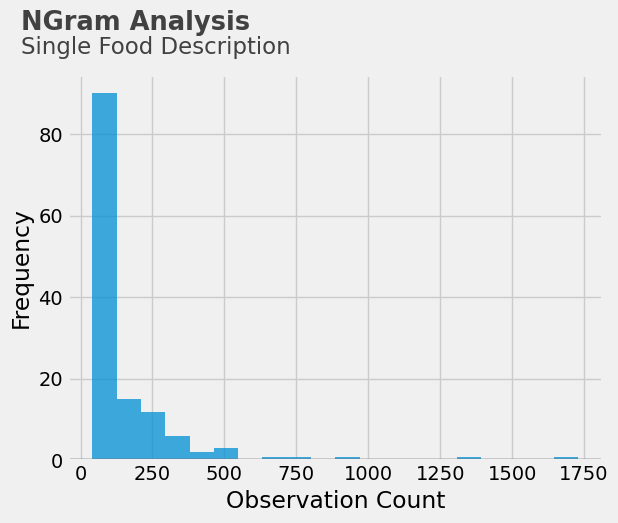

In [7]:
histogram(df = unigram, col = 'observation_count',output_prefix = f'{notebook_nm}-unigram',fig_dir = fig_dir, subtitle = 'Single Food Description', bins = 20,title ='NGram Analysis')

Image found in the "reports/figures" folder saved under 1.1-explorations_ngram_analysis_single_food_description_observation_count_boxplot.png


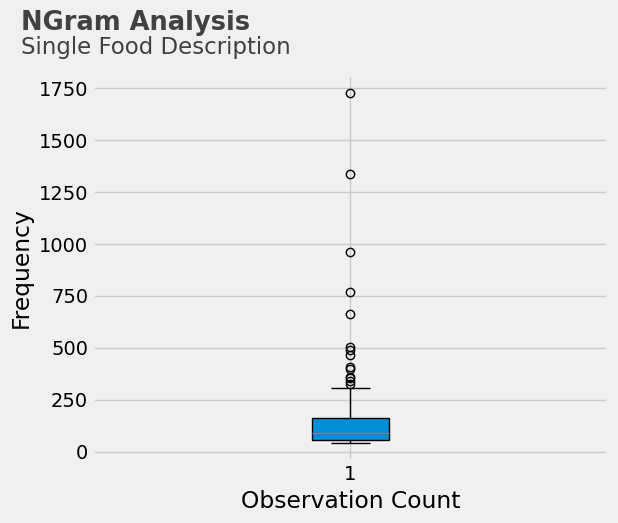

In [8]:
box_plot(df = unigram, col = 'observation_count', subtitle = 'Single Food Description', fig_dir = fig_dir,output_prefix = f'{notebook_nm}-unigram',title ='NGram Analysis')

Image found in the "reports/figures" folder saved under 1.1-explorations_ngram_analysis_most_common_single_food_description_food_combinations_observation_count_barchart.png


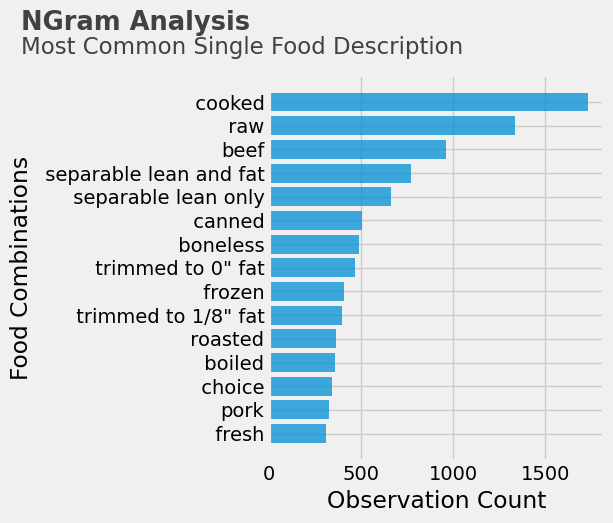

In [9]:
bar_plot(df = unigram,x = 'food_combinations',y = 'observation_count',title = 'NGram Analysis',subtitle = 'Most Common Single Food Description',fig_dir = fig_dir, output_prefix = f'{notebook_nm}-unigram', n_cols = 15)

Image found in the "reports/figures" folder saved under 1.1-explorations_ngram_analysis_duo_food_description_observation_count_hist.png


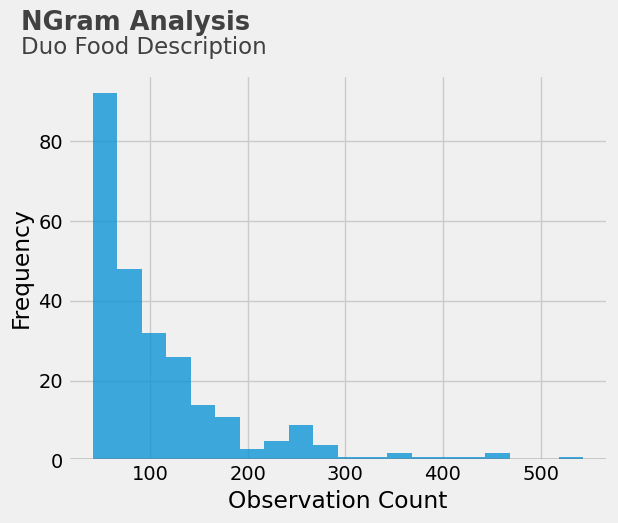

In [10]:
histogram(df = bigram, col = 'observation_count',output_prefix = f'{notebook_nm}-bigram',fig_dir = fig_dir, subtitle = 'Duo Food Description', bins = 20,title ='NGram Analysis')

Image found in the "reports/figures" folder saved under 1.1-explorations_ngram_analysis_duo_food_description_observation_count_boxplot.png


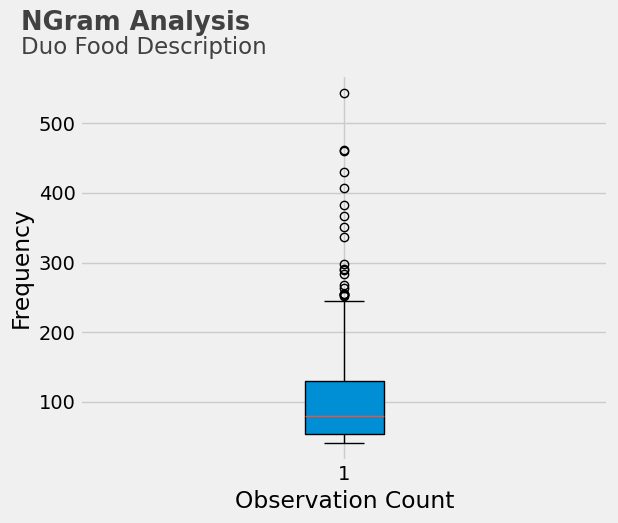

In [11]:
box_plot(df = bigram, col = 'observation_count', subtitle = 'Duo Food Description', fig_dir = fig_dir,output_prefix = f'{notebook_nm}-bigram',title ='NGram Analysis')

Image found in the "reports/figures" folder saved under 1.1-explorations_ngram_analysis_most_common_duo_food_description_food_combinations_observation_count_barchart.png


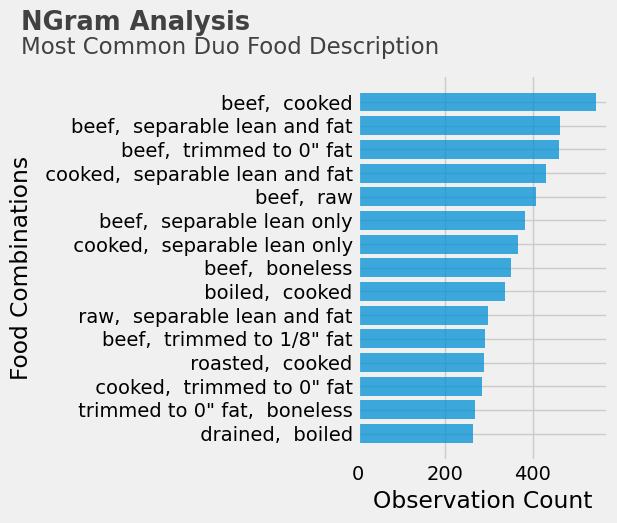

In [12]:
bar_plot(df = bigram,x = 'food_combinations',y = 'observation_count',title = 'NGram Analysis',subtitle = 'Most Common Duo Food Description',fig_dir = fig_dir, output_prefix = f'{notebook_nm}-bigram', n_cols = 15)

Image found in the "reports/figures" folder saved under 1.1-explorations_ngram_analysis_trio_food_description_observation_count_hist.png


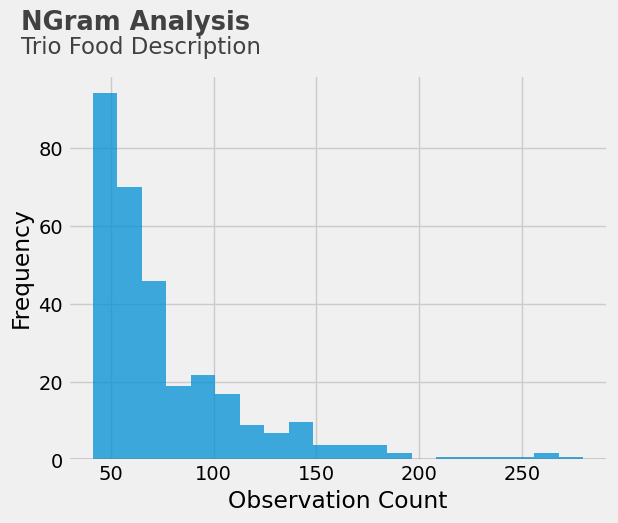

In [13]:
histogram(df = trigram, col = 'observation_count',output_prefix = f'{notebook_nm}-trigram',fig_dir = fig_dir, subtitle = 'Trio Food Description', bins = 20,title ='NGram Analysis')

Image found in the "reports/figures" folder saved under 1.1-explorations_ngram_analysis_trio_food_description_observation_count_boxplot.png


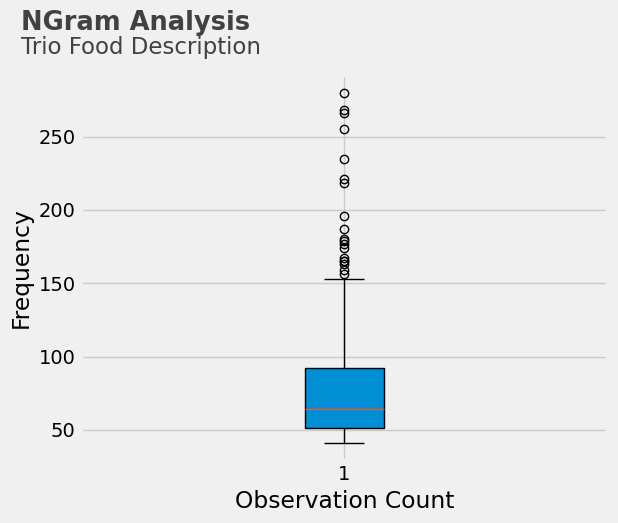

In [14]:
box_plot(df = trigram, col = 'observation_count', subtitle = 'Trio Food Description', fig_dir = fig_dir,output_prefix = f'{notebook_nm}-trigram',title ='NGram Analysis')

Image found in the "reports/figures" folder saved under 1.1-explorations_ngram_analysis_most_common_trio_food_description_food_combinations_observation_count_barchart.png


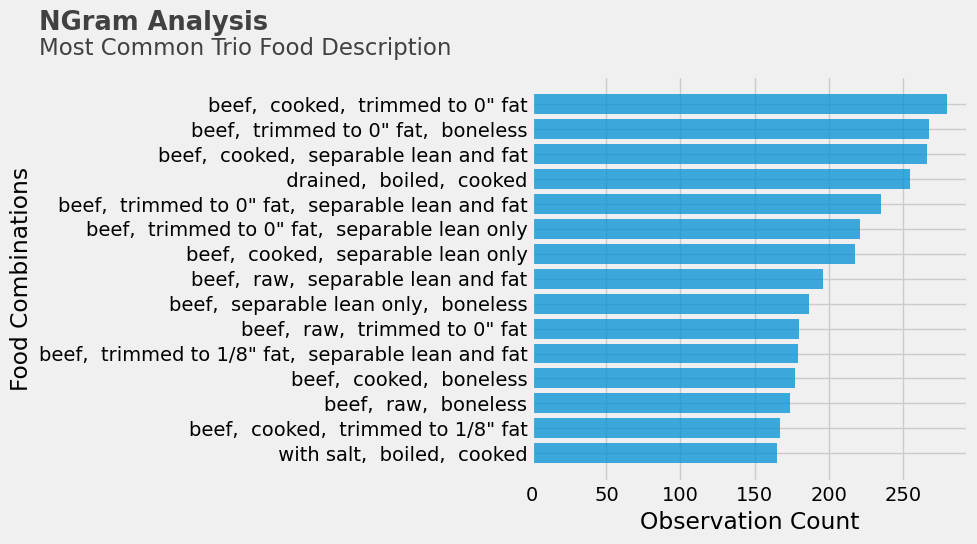

In [15]:
bar_plot(df = trigram,x = 'food_combinations',y = 'observation_count',title = 'NGram Analysis',subtitle = 'Most Common Trio Food Description',fig_dir = fig_dir, output_prefix = f'{notebook_nm}-trigram', n_cols = 15, width = 10, height = 5)

In [16]:
nutrition_df["name_short"] = nutrition_df["name_list"].str[0]
food_item_df = nutrition_df["name_short"].value_counts().rename_axis('food_item').reset_index(name = 'observation_count')
food_item_df = food_item_df[food_item_df.observation_count>10]

Image found in the "reports/figures" folder saved under 1.1-explorations_food_distribution_all_food_items_observation_count_hist.png


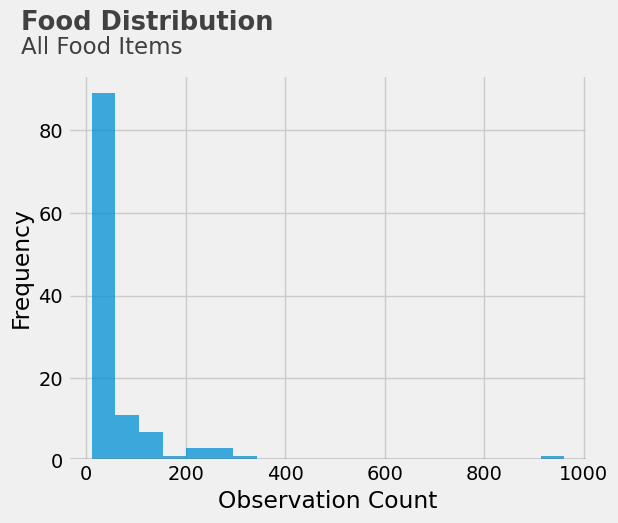

In [17]:
histogram(df = food_item_df, col = 'observation_count',output_prefix = f'{notebook_nm}-food-item',fig_dir = fig_dir, subtitle = 'All Food Items', bins = 20,title ='Food Distribution')

Image found in the "reports/figures" folder saved under 1.1-explorations_food_variability_analysis_all_food_items_observation_count_boxplot.png


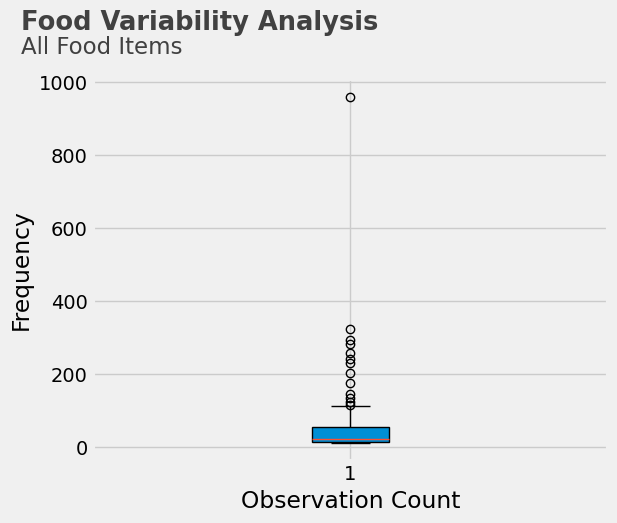

In [18]:
box_plot(df = food_item_df, col = 'observation_count', subtitle = 'All Food Items', fig_dir = fig_dir,output_prefix = f'{notebook_nm}-food-item',title ='Food Variability Analysis')

Image found in the "reports/figures" folder saved under 1.1-explorations_food_item_frequency_analysis_most_common_food_items_food_item_observation_count_barchart.png


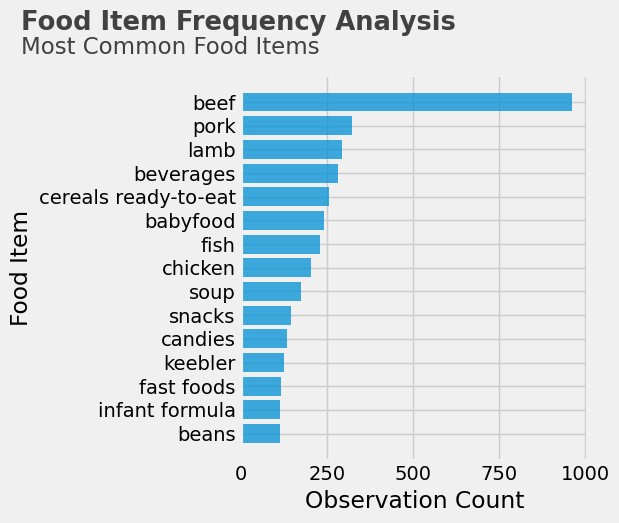

In [19]:
bar_plot(df = food_item_df,x = 'food_item',y = 'observation_count',title = 'Food Item Frequency Analysis',subtitle = 'Most Common Food Items',fig_dir = fig_dir, output_prefix = f'{notebook_nm}-food-item', n_cols = 15)

In [20]:
### 

Image found in the "reports/figures" folder saved under 1.1-explorations_variation_coefficient_all_nutrients_variation_coefficient_hist.png


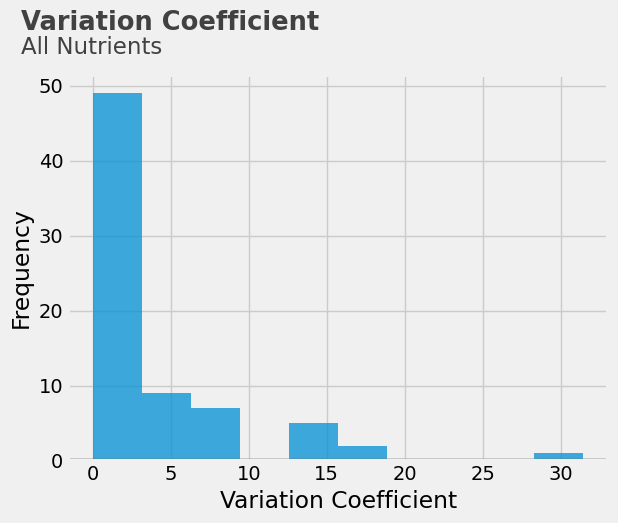

In [21]:
cv_list = np.std(nutrition_df, axis=0, ddof=1)/np.mean(nutrition_df, axis=0)
cv_df = cv_list.rename_axis('nutrient').reset_index(name='variation_coefficient').sort_values('variation_coefficient',ascending = False)
histogram(df = cv_df, col = 'variation_coefficient',output_prefix = f'{notebook_nm}-coefficient-variation',fig_dir = fig_dir, subtitle = 'All Nutrients', bins = 10)

Image found in the "reports/figures" folder saved under 1.1-explorations_variation_coefficient_all_nutrients_variation_coefficient_boxplot.png


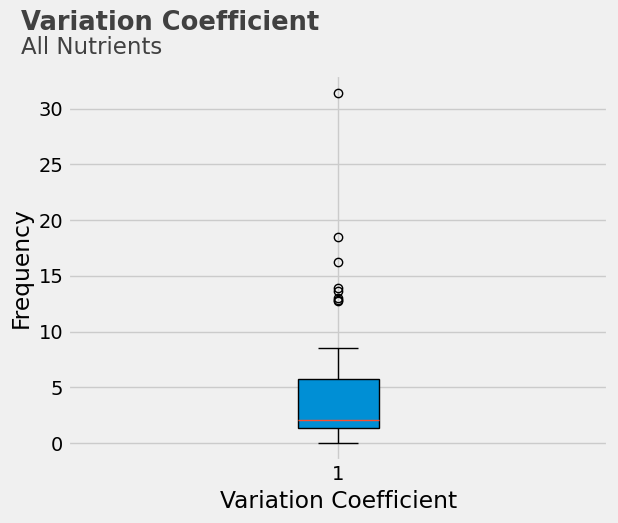

In [22]:
box_plot(df = cv_df, col = 'variation_coefficient', subtitle = 'All Nutrients', fig_dir = fig_dir,output_prefix = f'{notebook_nm}-coefficient-variation')

Image found in the "reports/figures" folder saved under 1.1-explorations_variation_analysis_top_varying_nutrients_nutrient_variation_coefficient_barchart.png


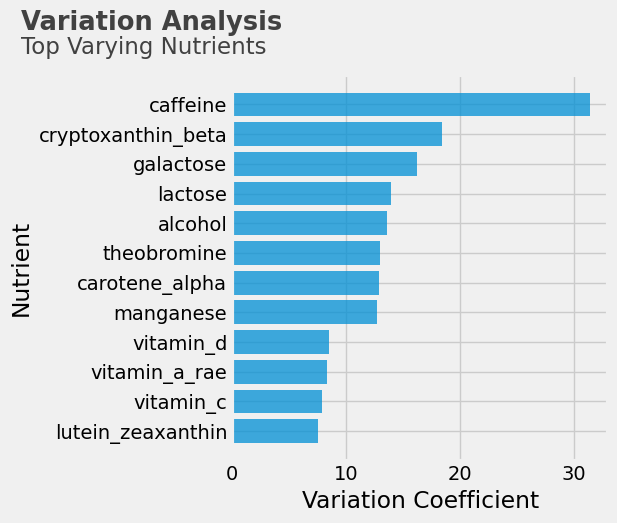

In [23]:
bar_plot(df = cv_df,x = 'nutrient',y = 'variation_coefficient',title = 'Variation Analysis',subtitle = 'Top Varying Nutrients',fig_dir = fig_dir, output_prefix = f'{notebook_nm}-coefficient-variation', n_cols = 12)

In [24]:
missing_df = (nutrition_df.isnull().mean() * 100).rename_axis('nutrient').reset_index(name='missing_rate').sort_values('missing_rate',ascending=False)
missing_df.head(10)

,nutrient,missing_rate
3,saturated_fat,18.090795
0,name,0.000000
48,phenylalanine,0.000000
55,carbohydrate,0.000000
54,valine,0.000000
53,tyrosine,0.000000
52,tryptophan,0.000000
51,threonine,0.000000
50,serine,0.000000
49,proline,0.000000


### Step 2: Clean Data

In [25]:
Q1 = nutrition_df.quantile(0.25)
Q3 = nutrition_df.quantile(0.75)
IQR = Q3 - Q1
outlier_df=(((nutrition_df < (Q1 - 1.5 * IQR)) | (nutrition_df > (Q3 + 1.5 * IQR))).sum()).rename_axis('nutrient').reset_index(name='outlier_count').sort_values('outlier_count',ascending = False)

Image found in the "reports/figures" folder saved under 1.1-explorations_outlier_analysis_top_nutrients_with_extreme_fields_nutrient_outlier_count_barchart.png


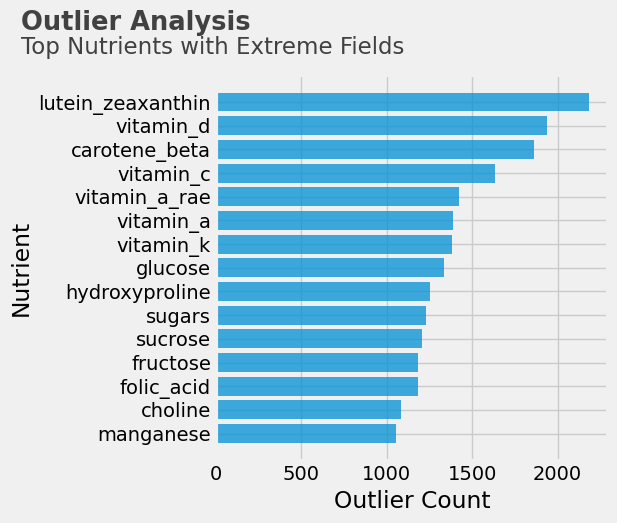

In [26]:
bar_plot(df = outlier_df,x = 'nutrient',y = 'outlier_count',title = 'Outlier Analysis',subtitle = 'Top Nutrients with Extreme Fields',fig_dir = fig_dir, output_prefix = f'{notebook_nm}-outliers', n_cols = 15)

Image found in the "reports/figures" folder saved under 1.1-explorations_outlier_analysis_variation_outlier_count_boxplot.png


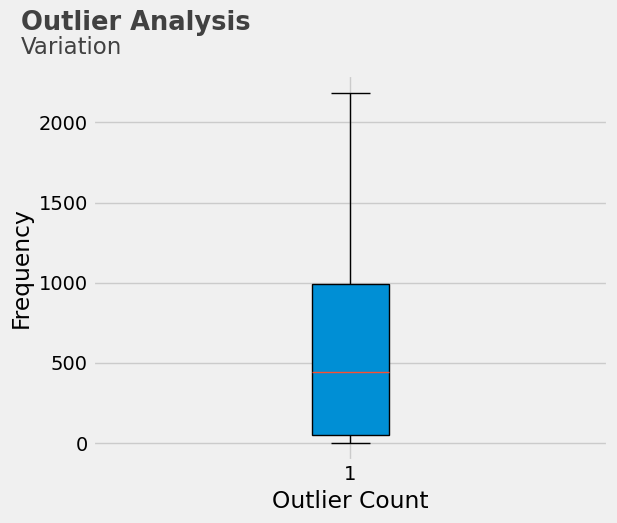

In [27]:
box_plot(df = outlier_df, col = 'outlier_count', subtitle = 'Variation', fig_dir = fig_dir,output_prefix = f'{notebook_nm}-outliers',title = 'Outlier Analysis')

Image found in the "reports/figures" folder saved under 1.1-explorations_outlier_analysis_distribution_outlier_count_hist.png


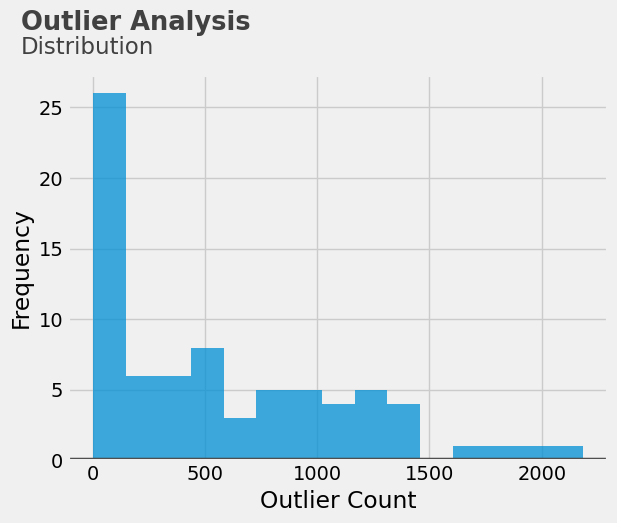

In [28]:
histogram(df = outlier_df, col = 'outlier_count',output_prefix = f'{notebook_nm}-outliers',fig_dir = fig_dir, subtitle = 'Distribution', bins = 15,title ='Outlier Analysis')

In [29]:
zero_counts_df = pd.DataFrame({'nutrient':nutrition_df.columns,
              'zero_value_counts':np.count_nonzero(nutrition_df.fillna(1)==0,axis=0),
               'observation_count':nutrition_df.shape[0]}).sort_values('zero_value_counts',ascending = False)
zero_counts_df['z_score_zero_value_counts'] = (zero_counts_df['zero_value_counts'] - zero_counts_df['zero_value_counts'].mean())/zero_counts_df['zero_value_counts'].std(ddof=1)
zero_counts_df['percent_zero'] = zero_counts_df['zero_value_counts'] / zero_counts_df['observation_count']
zero_counts_df.head(20)

,nutrient,zero_value_counts,observation_count,z_score_zero_value_counts,percent_zero
69,alcohol,8715,8789,1.964985,0.991580
59,galactose,8602,8789,1.922415,0.978723
72,theobromine,8545,8789,1.900942,0.972238
71,caffeine,8488,8789,1.879468,0.965753
61,lactose,8390,8789,1.842549,0.954602
62,maltose,8092,8789,1.730285,0.920696
15,carotene_alpha,8000,8789,1.695626,0.910229
17,cryptoxanthin_beta,7976,8789,1.686584,0.907498
8,folic_acid,7606,8789,1.547196,0.865400
58,fructose,7605,8789,1.546819,0.865286


Image found in the "reports/figures" folder saved under 1.1-explorations_nutrient_absence_distribution_nutrients_absent_from_food_percent_zero_hist.png


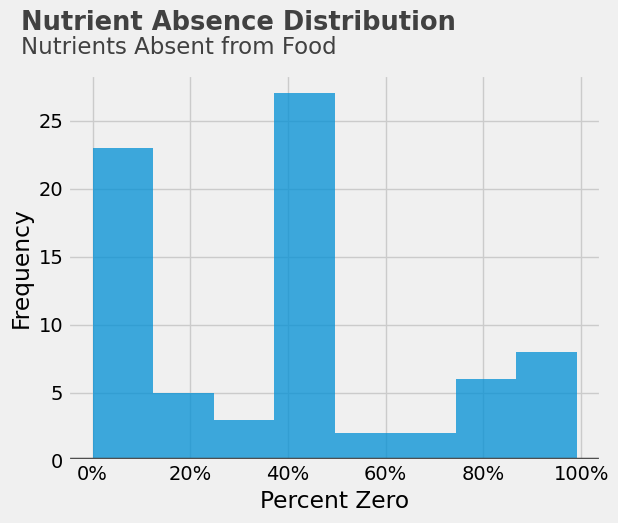

In [30]:
histogram(df = zero_counts_df, col = 'percent_zero',output_prefix = f'{notebook_nm}-zero-values',fig_dir = fig_dir, subtitle = 'Nutrients Absent from Food', bins = 8,title ='Nutrient Absence Distribution',percent_col = 'x')

Image found in the "reports/figures" folder saved under 1.1-explorations_no_nutrient_analysis_nutrients_absent_from_food_variation_percent_zero_boxplot.png


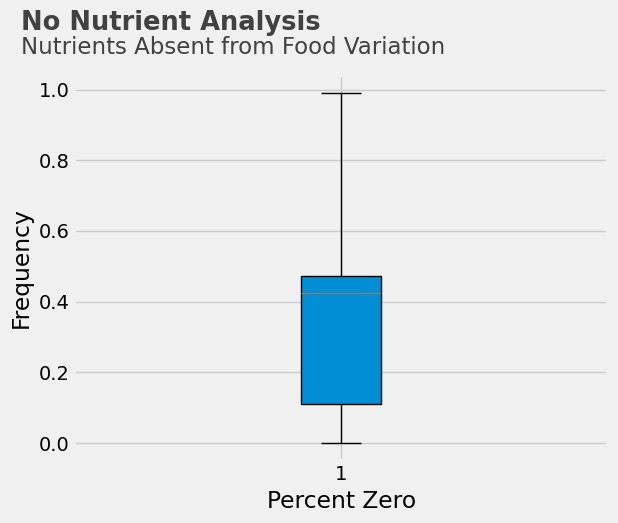

In [31]:
box_plot(df = zero_counts_df, col = 'percent_zero', subtitle = 'Nutrients Absent from Food Variation', fig_dir = fig_dir,output_prefix = f'{notebook_nm}-zero-values',title = 'No Nutrient Analysis')

Image found in the "reports/figures" folder saved under 1.1-explorations_no_nutrient_analysis_top_nutrients_absent_from_food_nutrient_percent_zero_barchart.png


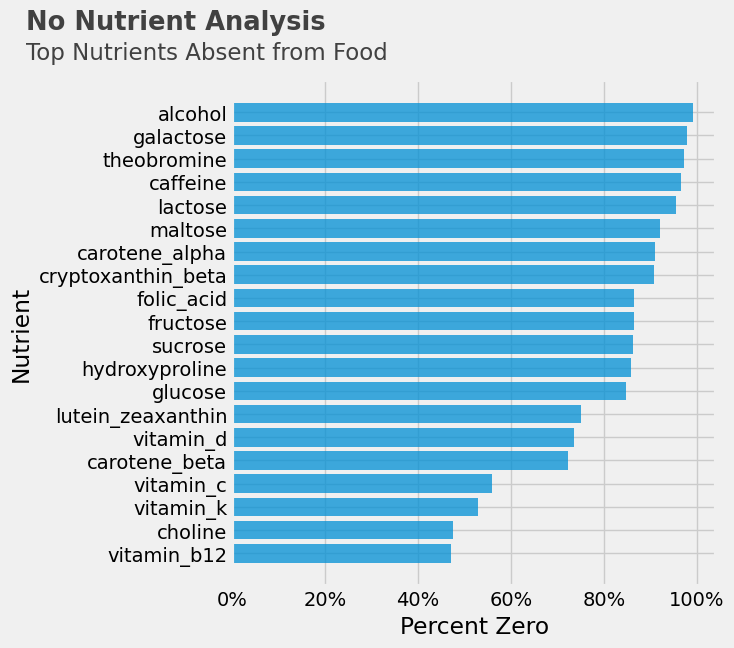

In [32]:
bar_plot(df = zero_counts_df,x = 'nutrient',y = 'percent_zero',title = 'No Nutrient Analysis',subtitle = 'Top Nutrients Absent from Food',fig_dir = fig_dir, output_prefix = f'{notebook_nm}-zero-values', height = 6, width =7.5,n_cols = 20,percent_col = 'x')

In [33]:
median_df = nutrition_df.median().rename_axis('nutrient').reset_index(name='median_value')

In [34]:
dfs = [zero_counts_df, outlier_df, cv_df, missing_df, median_df]
full_nutrient_df = ft.reduce(lambda left, right: pd.merge(left, right, on='nutrient'), dfs)
full_nutrient_df

,nutrient,zero_value_counts,observation_count,z_score_zero_value_counts,percent_zero,outlier_count,variation_coefficient,missing_rate,median_value
0,alcohol,8715,8789,1.964985,0.991580,74,13.615567,0.000000,0.00
1,galactose,8602,8789,1.922415,0.978723,187,16.214746,0.000000,0.00
2,theobromine,8545,8789,1.900942,0.972238,244,12.982805,0.000000,0.00
3,caffeine,8488,8789,1.879468,0.965753,301,31.458645,0.000000,0.00
4,lactose,8390,8789,1.842549,0.954602,399,13.917778,0.000000,0.00
...,...,...,...,...,...,...,...,...,...
68,protein,358,8789,-1.183318,0.040733,49,0.928165,0.000000,8.02
69,sodium,355,8789,-1.184448,0.040391,473,3.065803,0.000000,84.00
70,water,96,8789,-1.282020,0.010923,0,0.568690,0.000000,63.08
71,serving_size,0,8789,-1.318186,0.000000,0,0.000000,0.000000,100.00


In [35]:
full_nutrient_df['tertile_zero_value'] = pd.cut(full_nutrient_df['percent_zero'], 3, labels=[3,2,1])
full_nutrient_df

,nutrient,zero_value_counts,observation_count,z_score_zero_value_counts,percent_zero,outlier_count,variation_coefficient,missing_rate,median_value,tertile_zero_value
0,alcohol,8715,8789,1.964985,0.991580,74,13.615567,0.000000,0.00,1
1,galactose,8602,8789,1.922415,0.978723,187,16.214746,0.000000,0.00,1
2,theobromine,8545,8789,1.900942,0.972238,244,12.982805,0.000000,0.00,1
3,caffeine,8488,8789,1.879468,0.965753,301,31.458645,0.000000,0.00,1
4,lactose,8390,8789,1.842549,0.954602,399,13.917778,0.000000,0.00,1
...,...,...,...,...,...,...,...,...,...,...
68,protein,358,8789,-1.183318,0.040733,49,0.928165,0.000000,8.02,3
69,sodium,355,8789,-1.184448,0.040391,473,3.065803,0.000000,84.00,3
70,water,96,8789,-1.282020,0.010923,0,0.568690,0.000000,63.08,3
71,serving_size,0,8789,-1.318186,0.000000,0,0.000000,0.000000,100.00,3


In [36]:
tertile_1_zero_val_col_df = full_nutrient_df[full_nutrient_df['tertile_zero_value'] == 1]
tertile_2_zero_val_col_df = full_nutrient_df[full_nutrient_df['tertile_zero_value'] == 2]
tertile_3_zero_val_col_df = full_nutrient_df[full_nutrient_df['tertile_zero_value'] == 3]
tertile_1_zero_val_col_df.sort_values('percent_zero',ascending = True)

,nutrient,zero_value_counts,observation_count,z_score_zero_value_counts,percent_zero,outlier_count,variation_coefficient,missing_rate,median_value,tertile_zero_value
15,carotene_beta,6359,8789,1.077418,0.723518,1862,7.273375,0.0,0.0,1
14,vitamin_d,6469,8789,1.118858,0.736034,1938,8.491550,0.0,0.0,1
13,lutein_zeaxanthin,6603,8789,1.169339,0.751280,2186,7.550377,0.0,0.0,1
12,glucose,7453,8789,1.489556,0.847992,1336,5.859980,0.0,0.0,1
11,hydroxyproline,7533,8789,1.519695,0.857094,1256,3.043873,0.0,0.0,1
10,sucrose,7584,8789,1.538908,0.862897,1205,6.850190,0.0,0.0,1
9,fructose,7605,8789,1.546819,0.865286,1184,5.863018,0.0,0.0,1
8,folic_acid,7606,8789,1.547196,0.865400,1183,5.711113,0.0,0.0,1
7,cryptoxanthin_beta,7976,8789,1.686584,0.907498,813,18.482390,0.0,0.0,1
6,carotene_alpha,8000,8789,1.695626,0.910229,789,12.871048,0.0,0.0,1


In [37]:
full_nutrient_df[full_nutrient_df['nutrient'] == 'water']

,nutrient,zero_value_counts,observation_count,z_score_zero_value_counts,percent_zero,outlier_count,variation_coefficient,missing_rate,median_value,tertile_zero_value
70,water,96,8789,-1.28202,0.010923,0,0.56869,0.0,63.08,3


In [38]:
tertile_2_zero_val_col_df.sort_values('percent_zero',ascending = False)

,nutrient,zero_value_counts,observation_count,z_score_zero_value_counts,percent_zero,outlier_count,variation_coefficient,missing_rate,median_value,tertile_zero_value
16,vitamin_c,4911,8789,0.531918,0.558767,1631,7.853106,0.0,0.000,2
17,vitamin_k,4652,8789,0.434346,0.529298,1381,6.683193,0.0,0.000,2
18,choline,4183,8789,0.257661,0.475936,1085,2.167633,0.0,1.600,2
19,vitamin_b12,4135,8789,0.239578,0.470474,733,3.554841,0.0,0.070,2
20,cholesterol,4079,8789,0.218481,0.464103,184,3.030725,0.0,2.000,2
21,fatty_acids_total_trans,4079,8789,0.218481,0.464103,184,3.030725,0.0,2.000,2
22,fiber,4053,8789,0.208687,0.461145,805,2.092661,0.0,0.400,2
23,vitamin_a_rae,4025,8789,0.198138,0.457959,1422,8.365677,0.0,2.000,2
24,sugars,3966,8789,0.175911,0.451246,1230,2.030535,0.0,0.490,2
25,aspartic_acid,3949,8789,0.169507,0.449312,41,1.359617,0.0,0.145,2


In [39]:
tertile_3_zero_val_col_df

,nutrient,zero_value_counts,observation_count,z_score_zero_value_counts,percent_zero,outlier_count,variation_coefficient,missing_rate,median_value,tertile_zero_value
46,pantothenic_acid,2497,8789,-0.377500,0.284105,301,2.584456,0.000000,0.274,3
47,manganese,2339,8789,-0.437022,0.266128,1054,12.708819,0.000000,0.022,3
48,carbohydrate,2158,8789,-0.505210,0.245534,110,1.232545,0.000000,9.340,3
49,selenium,2090,8789,-0.530827,0.237797,165,2.169585,0.000000,4.000,3
50,folate,1896,8789,-0.603912,0.215724,1016,2.895969,0.000000,9.000,3
51,copper,1515,8789,-0.747445,0.172375,891,3.244678,0.000000,0.077,3
52,vitamin_b6,1278,8789,-0.836729,0.145409,409,1.789784,0.000000,0.119,3
53,monounsaturated_fatty_acids,1017,8789,-0.935055,0.115713,547,1.809562,0.000000,1.600,3
54,magnesium,1000,8789,-0.941459,0.113779,1003,1.730759,0.000000,20.000,3
55,polyunsaturated_fatty_acids,992,8789,-0.944473,0.112868,982,2.388482,0.000000,0.591,3


Image found in the "reports/figures" folder saved under 1.1-explorations_variation_analysis_nutrient_with_67%+_of_observations_with_value_0_nutrient_variation_coefficient_barchart.png


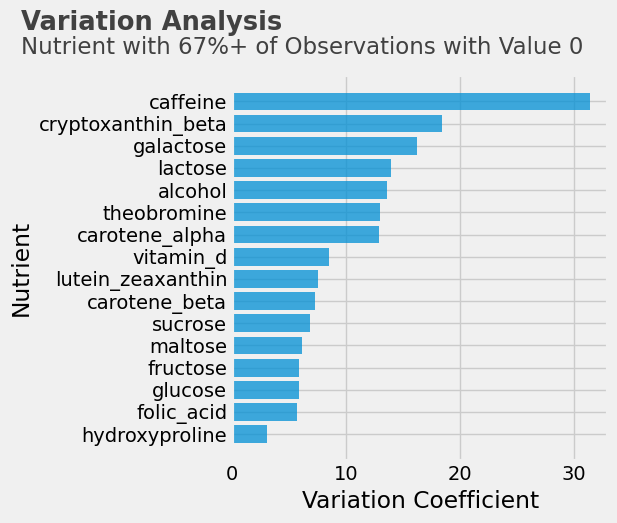

In [40]:
bar_plot(df = tertile_1_zero_val_col_df,x = 'nutrient',y = 'variation_coefficient',title = 'Variation Analysis',subtitle = 'Nutrient with 67%+ of Observations with Value 0',fig_dir = fig_dir, output_prefix = f'{notebook_nm}-zero-value-tert-1-coefficient-variation', n_cols = 17)

Image found in the "reports/figures" folder saved under 1.1-explorations_variation_analysis_nutrient_with_33%_to_67%_of_observations_with_value_0_nutrient_variation_coefficient_barchart.png


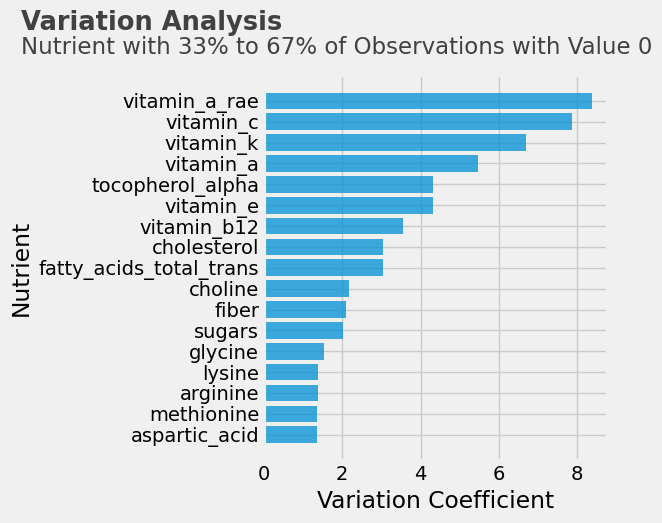

In [41]:
bar_plot(df = tertile_2_zero_val_col_df,x = 'nutrient',y = 'variation_coefficient',title = 'Variation Analysis',subtitle = 'Nutrient with 33% to 67% of Observations with Value 0',fig_dir = fig_dir, output_prefix = f'{notebook_nm}-zero-value-tert-2-coefficient-variation', n_cols = 17)

Image found in the "reports/figures" folder saved under 1.1-explorations_variation_analysis_nutrient_with_0%_to_33%_of_observations_with_value_0_nutrient_variation_coefficient_barchart.png


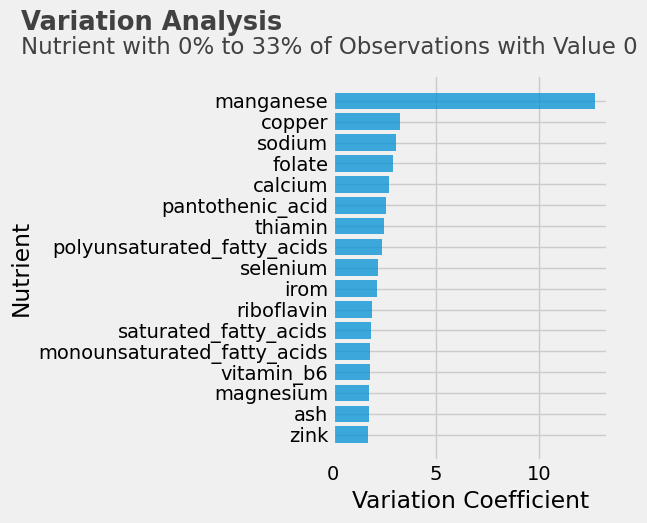

In [42]:
bar_plot(df = tertile_3_zero_val_col_df,x = 'nutrient',y = 'variation_coefficient',title = 'Variation Analysis',subtitle = 'Nutrient with 0% to 33% of Observations with Value 0',fig_dir = fig_dir, output_prefix = f'{notebook_nm}-zero-value-tert-3-coefficient-variation', n_cols = 17)

In [43]:
nutrition_df[['name','carotene_beta']].nlargest(45,'carotene_beta')

,name,carotene_beta
1607,"Peppers, freeze-dried, red, sweet",42891.0
304,"Carrot, dehydrated",33954.0
462,"Spices, paprika",26162.0
1975,"Spices, red or cayenne, pepper",21840.0
377,"Grape leaves, raw",16194.0
149,"Spices, chili powder",15000.0
2035,"Peppers, sun-dried, hot chile",14844.0
2551,"Snacks, unsalted, sweet potato chips",14205.0
4721,"Sweet potato, without salt, baked, cooked, frozen",12498.0
5013,"Sweet potato, without salt, flesh, baked in sk...",11509.0


Image found in the "reports/figures" folder saved under 1.1-explorations_mask_variable_selection_tertile_1_zero_value:_caffeine_distribution_caffeine_hist.png


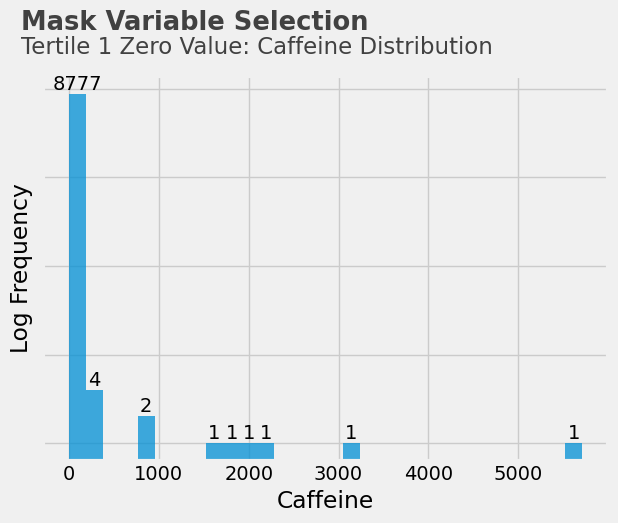

In [44]:
histogram(df = nutrition_df, col = 'caffeine',output_prefix = f'{notebook_nm}-caffeine-var-sel',fig_dir = fig_dir, title = 'Mask Variable Selection', subtitle = 'Tertile 1 Zero Value: Caffeine Distribution', bins = 30, log_scale = True)

Image found in the "reports/figures" folder saved under 1.1-explorations_mask_variable_selection_tertile_1_zero_value:_lactose_distribution_lactose_hist.png


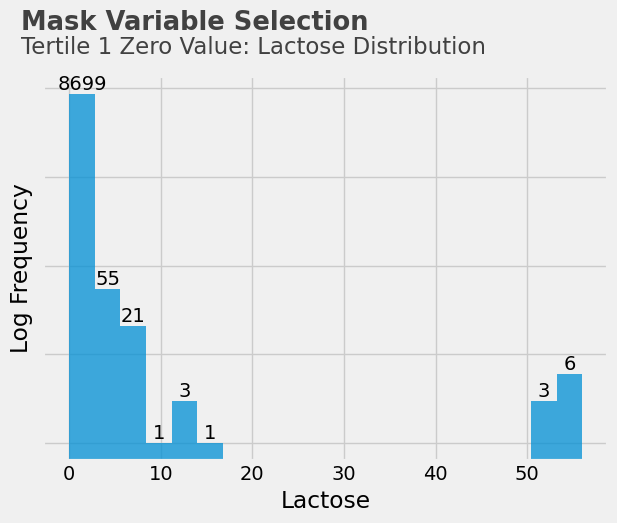

In [45]:
histogram(df = nutrition_df, col = 'lactose',output_prefix = f'{notebook_nm}-lactose-var-sel',fig_dir = fig_dir, title = 'Mask Variable Selection', subtitle = 'Tertile 1 Zero Value: Lactose Distribution', bins = 20, log_scale = True)

Image found in the "reports/figures" folder saved under 1.1-explorations_mask_variable_selection_tertile_1_zero_value:_fructose_distribution_fructose_hist.png


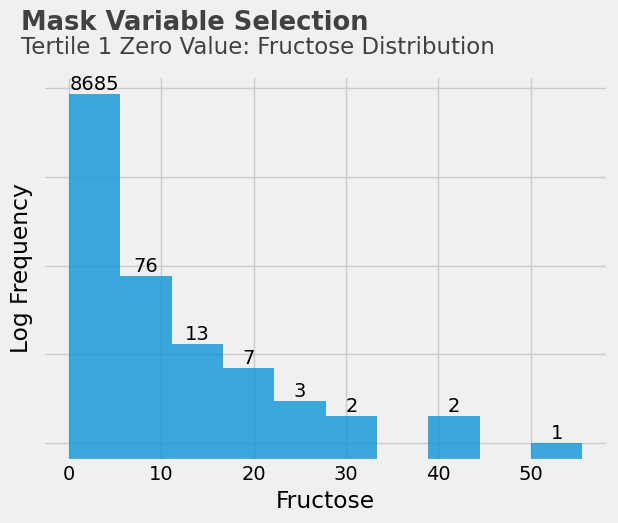

In [46]:
histogram(df = nutrition_df, col = 'fructose',output_prefix = f'{notebook_nm}-fructose-var-sel',fig_dir = fig_dir, title = 'Mask Variable Selection', subtitle = 'Tertile 1 Zero Value: Fructose Distribution', bins = 10, log_scale = True)

In [47]:
pd.set_option('display.max_columns',None)
nutrition_df.median().rename_axis('nutrient').reset_index(name='median_value')

,nutrient,median_value
0,serving_size,100.00
1,total_fat,5.10
2,saturated_fat,2.20
3,cholesterol,2.00
4,sodium,84.00
...,...,...
68,alcohol,0.00
69,ash,1.17
70,caffeine,0.00
71,theobromine,0.00


Image found in the "reports/figures" folder saved under 1.1-explorations_mask_variable_selection_tertile_1_zero_value:_glucose_distribution_total_fat_hist.png


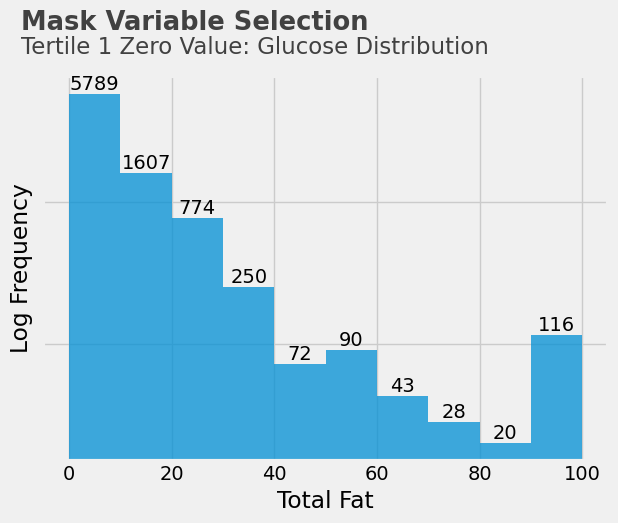

In [48]:
histogram(df = nutrition_df, col = 'total_fat',output_prefix = f'{notebook_nm}-glucose-var-sel',fig_dir = fig_dir, title = 'Mask Variable Selection', subtitle = 'Tertile 1 Zero Value: Glucose Distribution', bins = 10, log_scale = True)

Image found in the "reports/figures" folder saved under 1.1-explorations_mask_variable_selection_tertile_1_zero_value:_glucose_distribution_glucose_hist.png


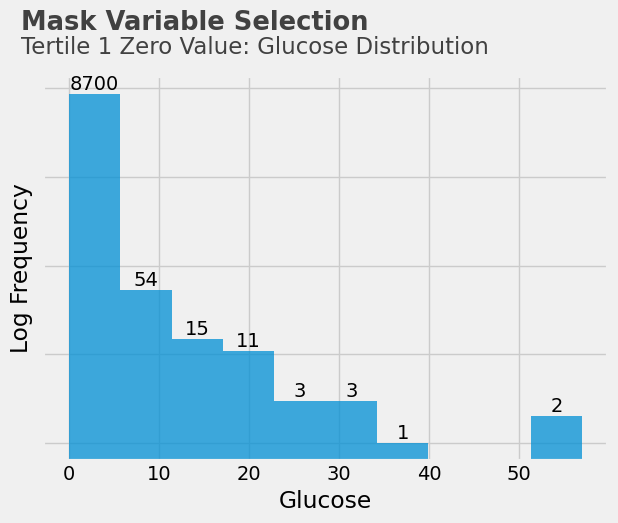

In [49]:
histogram(df = nutrition_df, col = 'glucose',output_prefix = f'{notebook_nm}-glucose-var-sel',fig_dir = fig_dir, title = 'Mask Variable Selection', subtitle = 'Tertile 1 Zero Value: Glucose Distribution', bins = 10, log_scale = True)

Image found in the "reports/figures" folder saved under 1.1-explorations_mask_variable_selection_tertile_1_zero_value:_cryptoxanthin_beta_distribution_cryptoxanthin_beta_hist.png


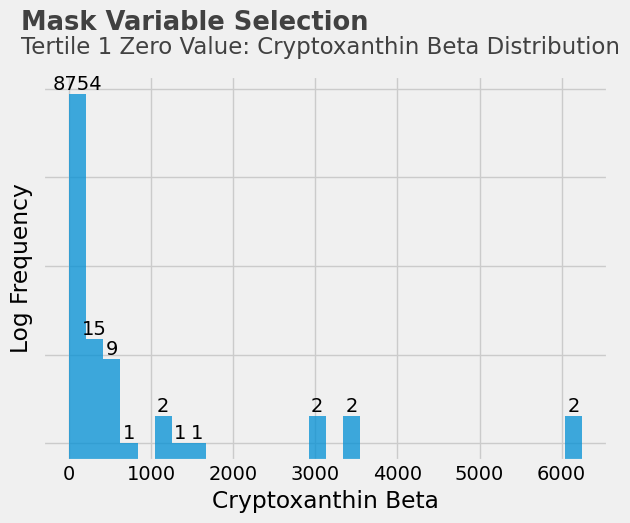

In [50]:
histogram(df = nutrition_df, col = 'cryptoxanthin_beta',output_prefix = f'{notebook_nm}-cryptoxanthin_beta-var-sel',fig_dir = fig_dir, title = 'Mask Variable Selection', subtitle = 'Tertile 1 Zero Value: Cryptoxanthin Beta Distribution', bins = 30, log_scale = True)

Image found in the "reports/figures" folder saved under 1.1-explorations_mask_variable_selection_tertile_1_zero_value:_alcohol_distribution_alcohol_hist.png


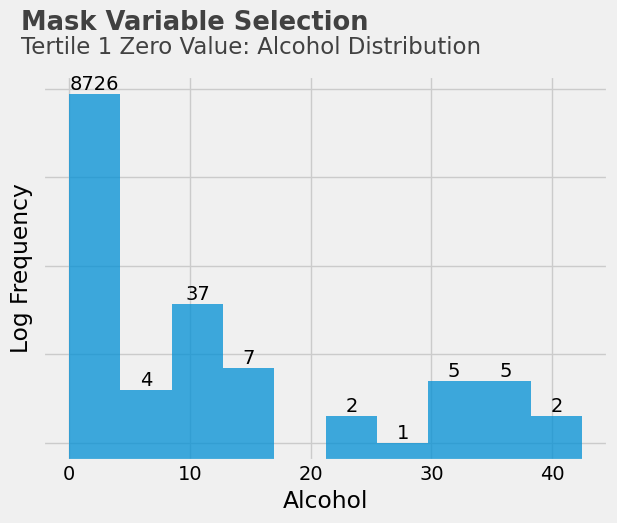

In [51]:
histogram(df = nutrition_df, col = 'alcohol',output_prefix = f'{notebook_nm}-alcohol-var-sel',fig_dir = fig_dir, title = 'Mask Variable Selection', subtitle = 'Tertile 1 Zero Value: Alcohol Distribution', bins = 10, log_scale = True)

Image found in the "reports/figures" folder saved under 1.1-explorations_mask_variable_selection_tertile_1_zero_value:_theobromine_distribution_theobromine_hist.png


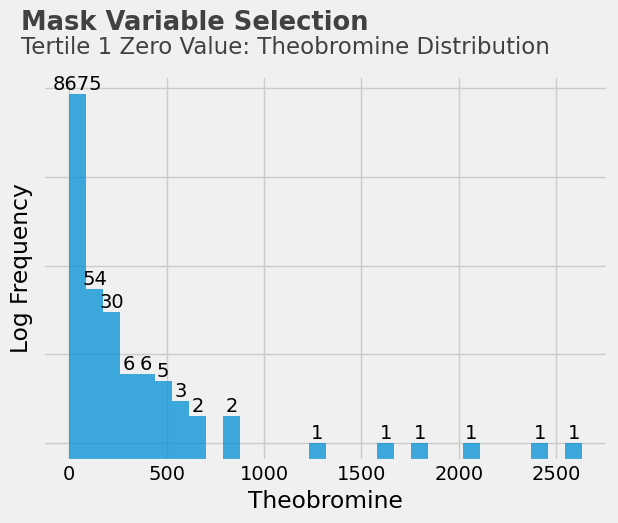

In [52]:
histogram(df = nutrition_df, col = 'theobromine',output_prefix = f'{notebook_nm}-theobromine-var-sel',fig_dir = fig_dir, title = 'Mask Variable Selection', subtitle = 'Tertile 1 Zero Value: Theobromine Distribution', bins = 30, log_scale = True)

Image found in the "reports/figures" folder saved under 1.1-explorations_mask_variable_selection_tertile_2_zero_value:_vitamin_a_rae_distribution_vitamin_a_rae_hist.png


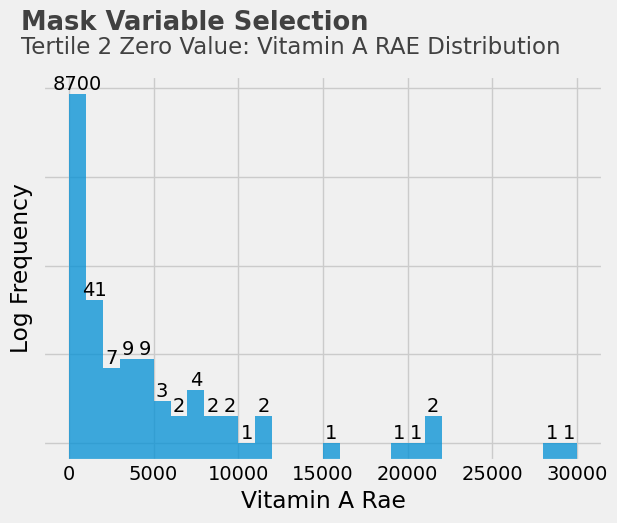

In [53]:
histogram(df = nutrition_df, col = 'vitamin_a_rae',output_prefix = f'{notebook_nm}-vitamin_a_rae-var-sel',fig_dir = fig_dir, title = 'Mask Variable Selection', subtitle = 'Tertile 2 Zero Value: Vitamin A RAE Distribution', bins = 30, log_scale = True)

Image found in the "reports/figures" folder saved under 1.1-explorations_mask_variable_selection_tertile_2_zero_value:_vitamin_b12_distribution_vitamin_b12_hist.png


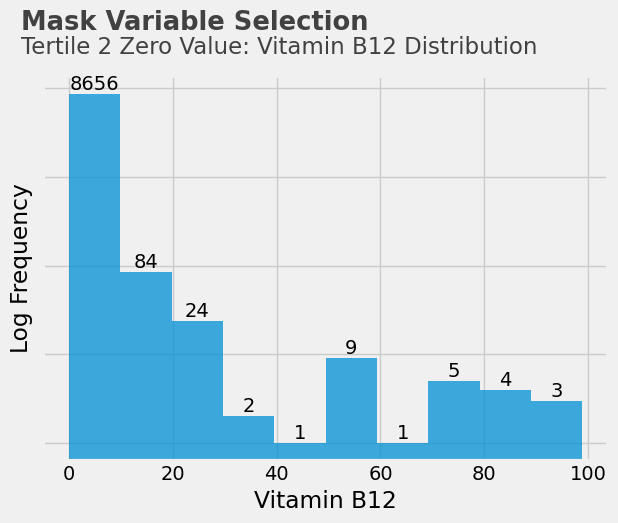

In [54]:
histogram(df = nutrition_df, col = 'vitamin_b12',output_prefix = f'{notebook_nm}-vitamin_b12-var-sel',fig_dir = fig_dir, title = 'Mask Variable Selection', subtitle = 'Tertile 2 Zero Value: Vitamin B12 Distribution', bins = 10, log_scale = True)

Image found in the "reports/figures" folder saved under 1.1-explorations_mask_variable_selection_tertile_2_zero_value:_cholesterol_distribution_cholesterol_hist.png


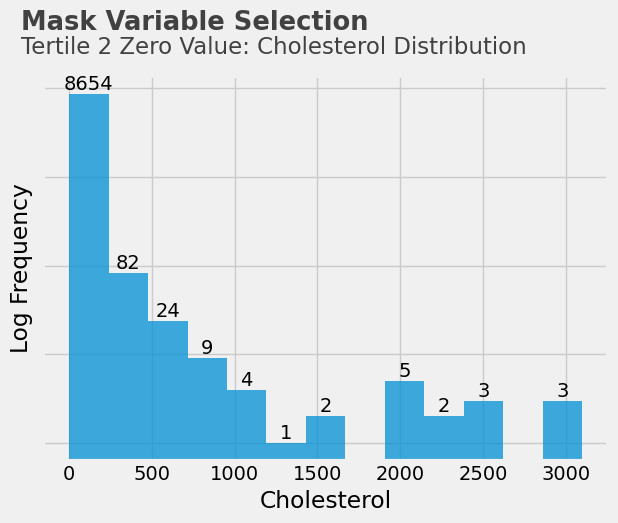

In [55]:
histogram(df = nutrition_df, col = 'cholesterol',output_prefix = f'{notebook_nm}-cholesterol-var-sel',fig_dir = fig_dir, title = 'Mask Variable Selection', subtitle = 'Tertile 2 Zero Value: Cholesterol Distribution', bins = 13, log_scale = True)

Image found in the "reports/figures" folder saved under 1.1-explorations_mask_variable_selection_tertile_2_zero_value:_fiber_distribution_fiber_hist.png


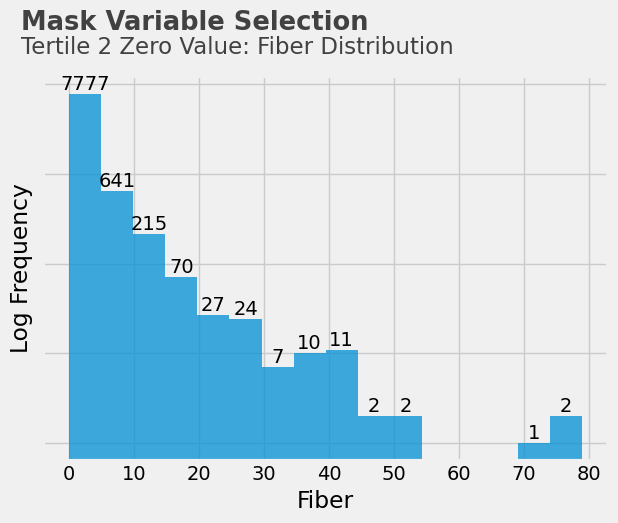

In [56]:
histogram(df = nutrition_df, col = 'fiber',output_prefix = f'{notebook_nm}-fiber-var-sel',fig_dir = fig_dir, title = 'Mask Variable Selection', subtitle = 'Tertile 2 Zero Value: Fiber Distribution', bins = 16, log_scale = True)

Image found in the "reports/figures" folder saved under 1.1-explorations_mask_variable_selection_tertile_2_zero_value:_sugar_distribution_sugars_hist.png


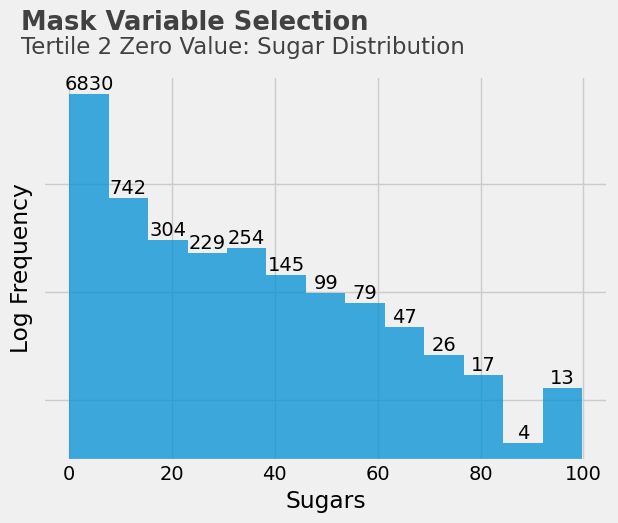

In [57]:
histogram(df = nutrition_df, col = 'sugars',output_prefix = f'{notebook_nm}-sugar-var-sel',fig_dir = fig_dir, title = 'Mask Variable Selection', subtitle = 'Tertile 2 Zero Value: Sugar Distribution', bins = 13, log_scale = True)

Image found in the "reports/figures" folder saved under 1.1-explorations_variation_analysis_nutrient_with_0%_to_33%_of_observations_with_value_0_nutrient_variation_coefficient_barchart.png


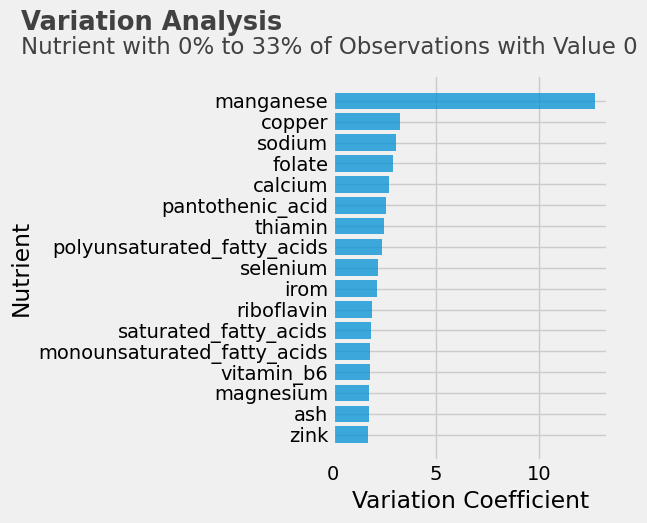

In [58]:
bar_plot(df = tertile_3_zero_val_col_df,x = 'nutrient',y = 'variation_coefficient',title = 'Variation Analysis',subtitle = 'Nutrient with 0% to 33% of Observations with Value 0',fig_dir = fig_dir, output_prefix = f'{notebook_nm}-zero-value-tert-3-coefficient-variation', n_cols = 17)

Image found in the "reports/figures" folder saved under 1.1-explorations_mask_variable_selection_tertile_3_zero_value:_manganese_distribution_manganese_hist.png


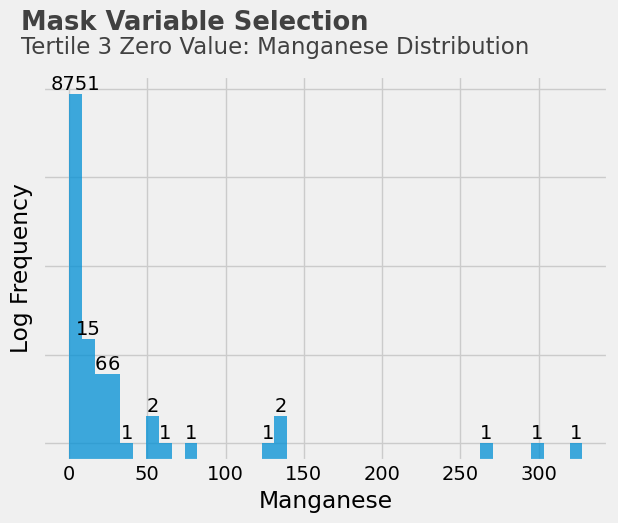

In [59]:
histogram(df = nutrition_df, col = 'manganese',output_prefix = f'{notebook_nm}-manganese-var-sel',fig_dir = fig_dir, title = 'Mask Variable Selection', subtitle = 'Tertile 3 Zero Value: Manganese Distribution', bins = 40, log_scale = True)

Image found in the "reports/figures" folder saved under 1.1-explorations_mask_variable_selection_tertile_3_zero_value:_zink_distribution_zink_hist.png


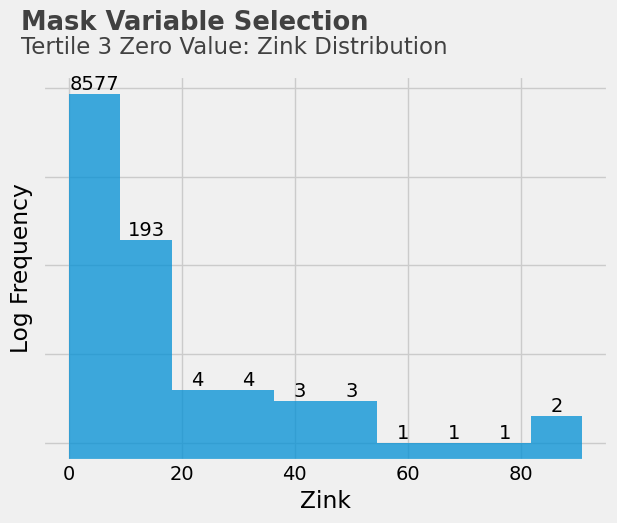

In [60]:
histogram(df = nutrition_df, col = 'zink',output_prefix = f'{notebook_nm}-zink-var-sel',fig_dir = fig_dir, title = 'Mask Variable Selection', subtitle = 'Tertile 3 Zero Value: Zink Distribution', bins = 10, log_scale = True)

Image found in the "reports/figures" folder saved under 1.1-explorations_mask_variable_selection_tertile_3_zero_value:_thiamin_distribution_thiamin_hist.png


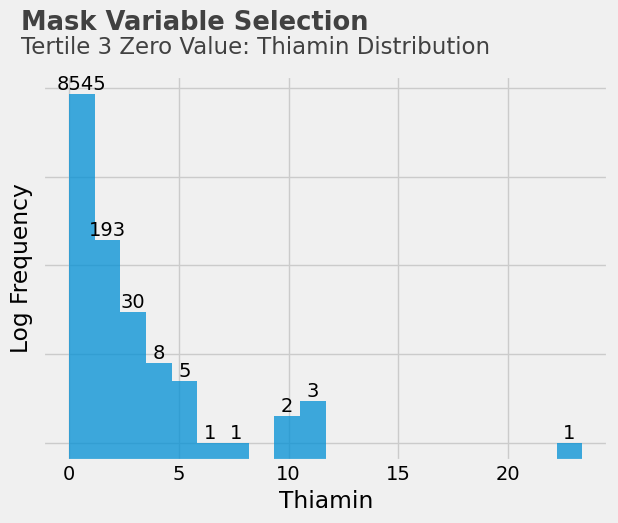

In [61]:
histogram(df = nutrition_df, col = 'thiamin',output_prefix = f'{notebook_nm}-thiamin-var-sel',fig_dir = fig_dir, title = 'Mask Variable Selection', subtitle = 'Tertile 3 Zero Value: Thiamin Distribution', bins = 20, log_scale = True)

Image found in the "reports/figures" folder saved under 1.1-explorations_mask_variable_selection_tertile_3_zero_value:_sodium_distribution_sodium_hist.png


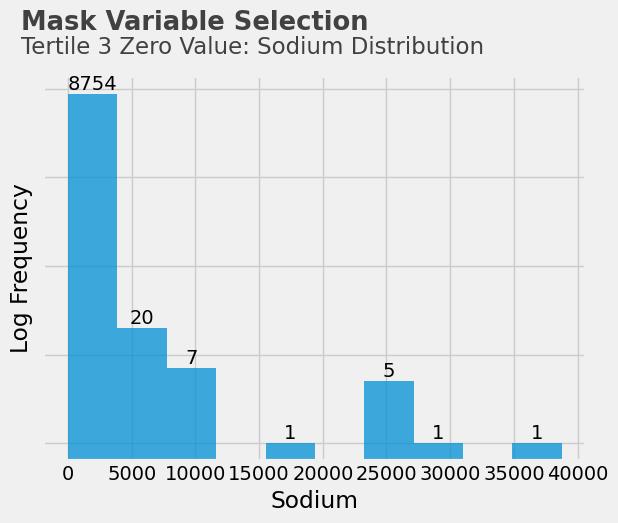

In [62]:
histogram(df = nutrition_df, col = 'sodium',output_prefix = f'{notebook_nm}-sodium-var-sel',fig_dir = fig_dir, title = 'Mask Variable Selection', subtitle = 'Tertile 3 Zero Value: Sodium Distribution', bins = 10, log_scale = True)

Image found in the "reports/figures" folder saved under 1.1-explorations_mask_variable_selection_tertile_3_zero_value:_water_distribution_water_hist.png


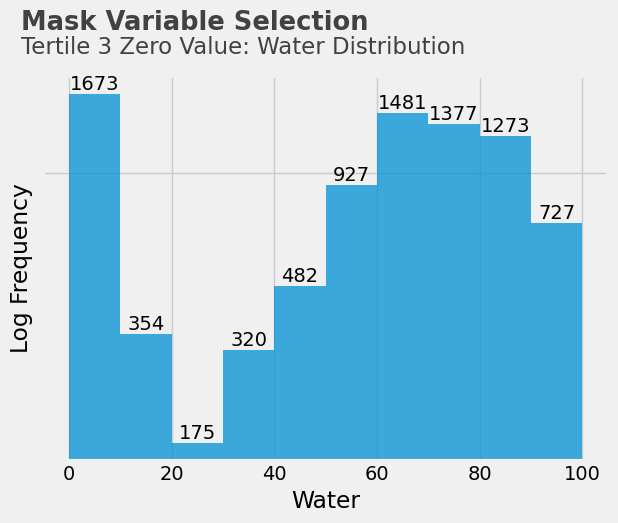

In [63]:
histogram(df = nutrition_df, col = 'water',output_prefix = f'{notebook_nm}-water-var-sel',fig_dir = fig_dir, title = 'Mask Variable Selection', subtitle = 'Tertile 3 Zero Value: Water Distribution', bins = 10, log_scale = True)

Image found in the "reports/figures" folder saved under 1.1-explorations_mask_variable_selection_tertile_3_zero_value:_protein_distribution_protein_hist.png


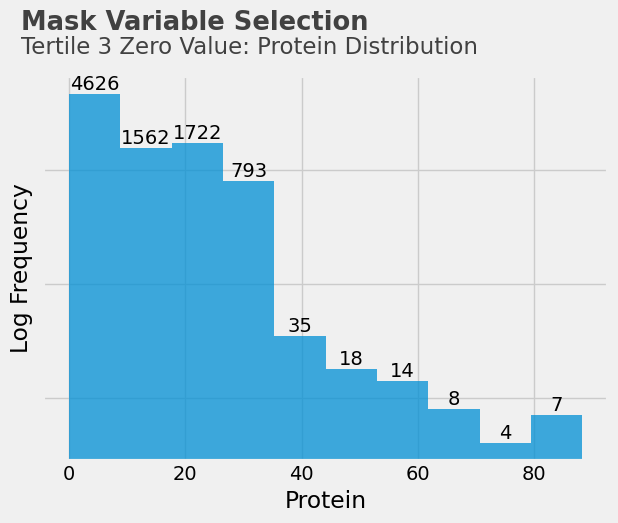

In [64]:
histogram(df = nutrition_df, col = 'protein',output_prefix = f'{notebook_nm}-protein-var-sel',fig_dir = fig_dir, title = 'Mask Variable Selection', subtitle = 'Tertile 3 Zero Value: Protein Distribution', bins = 10, log_scale = True)

### Step 3: Output Data 

In [65]:
full_nutrient_df[full_nutrient_df.nutrient == 'water']

,nutrient,zero_value_counts,observation_count,z_score_zero_value_counts,percent_zero,outlier_count,variation_coefficient,missing_rate,median_value,tertile_zero_value
70,water,96,8789,-1.28202,0.010923,0,0.56869,0.0,63.08,3


In [66]:
full_nutrient_df.to_csv(f'{ROOT_DIR}/data/interim/nutrition_facts_statistics.csv', index=False)